In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import OLSInfluence

In [19]:
org_df = pd.read_csv('./1.설탕소비.csv')
org_df

,year,sugar_consum
0,1822,6.33680
1,1823,6.40800
2,1824,6.26560
3,1825,5.69600
4,1826,6.55040
...,...,...
179,2001,104.67112
180,2002,104.01608
181,2003,100.61984
182,2004,100.80496


In [20]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          184 non-null    int64  
 1   sugar_consum  184 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.0 KB


In [36]:
df_dict = {}
for era in [(1822, 1930), (1931, 1960), (1961, 2005)]:
    key = f"{era[0]}~{era[1]}"
    df_dict[key] = org_df.loc[(org_df['year'] >= era[0]) & (org_df['year'] <= era[1])]


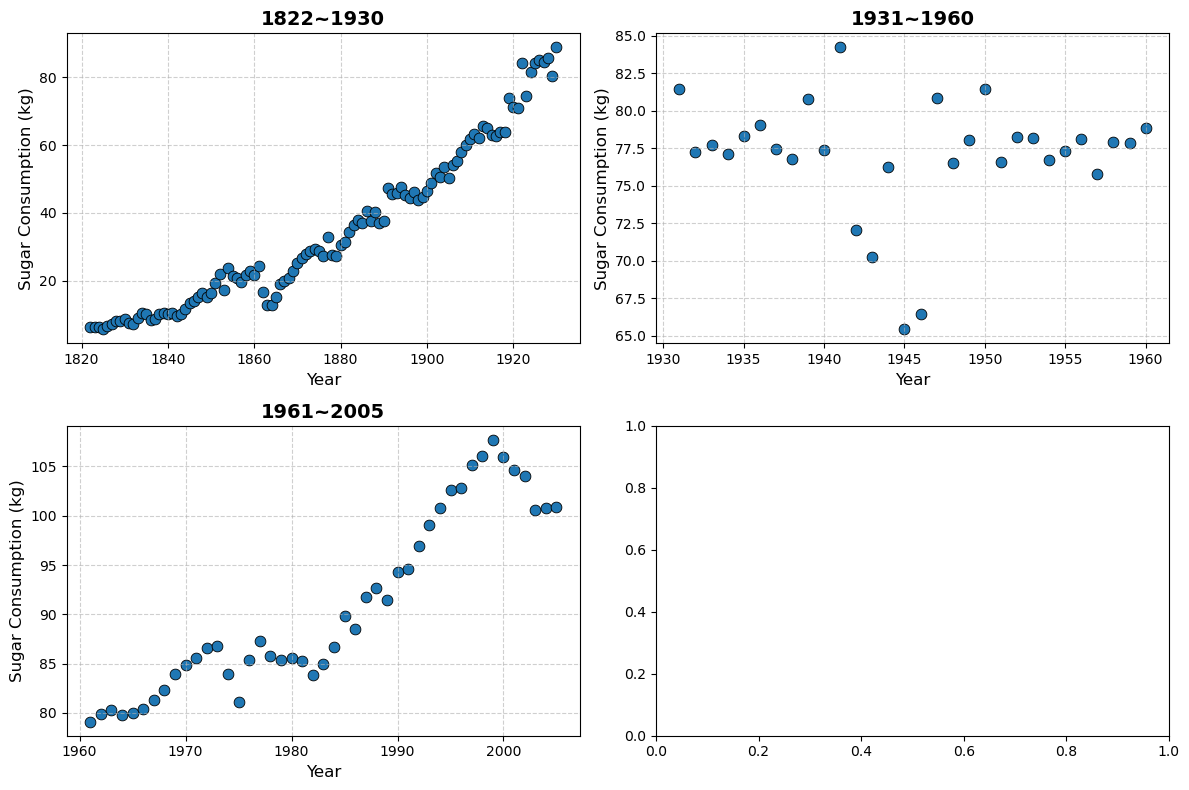

In [38]:
import matplotlib.pyplot as plt

# figure 및 axes 생성
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=100)

# 축을 일차원 배열로 변환
axes = axes.flatten()

# 각 데이터프레임에 대해 산점도 그리기
for i, (key, df) in enumerate(df_dict.items()):
    axes[i].scatter(df['year'], df['sugar_consum'], color='#1f77b4', marker='o', s=60, edgecolor='black', linewidth=0.6)
    axes[i].set_title(key, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Year', fontsize=12)
    axes[i].set_ylabel('Sugar Consumption (kg)', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# 레이아웃 조정
plt.tight_layout()
plt.show()


In [40]:
def diagnostic_plots(model, independent_var):
    # 필요한 값들 계산
    fitted_vals = model.fittedvalues
    resids = model.resid
    stand_resids = model.get_influence().resid_studentized_internal
    sqrt_stand_resids = np.sqrt(np.abs(stand_resids))
    
    # Cook's distance 계산
    influence = model.get_influence()
    cooks = influence.cooks_distance[0]

    # 2x2 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    # 1. 잔차 vs 적합값
    axes[0, 0].scatter(fitted_vals, resids)
    axes[0, 0].set_xlabel('Fitted values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted')
    axes[0, 0].axhline(y=0, color='r', linestyle='--')

    # 2. 정규확률그림 (Q-Q plot)
    QQ = ProbPlot(stand_resids)
    QQ.qqplot(line='45', ax=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q')

    # 3. 표준화 잔차 제곱근 vs 적합값
    axes[1, 0].scatter(fitted_vals, sqrt_stand_resids)
    axes[1, 0].set_xlabel('Fitted values')
    axes[1, 0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    axes[1, 0].set_title('Scale-Location')

    # 4. Cook's Distance
    axes[1, 1].stem(model.fittedvalues, cooks, markerfmt=",")
    axes[1, 1].set_xlabel('Fitted values')
    axes[1, 1].set_ylabel("Cook's distance")
    axes[1, 1].set_title("Cook's Distance")

    plt.tight_layout()
    plt.show()


In [41]:
def linear_regression_analysis(data, column_names):
    """
    Perform linear regression analysis on the specified columns of a DataFrame.

    Parameters:
    - data: pd.DataFrame containing the data.
    - column_names: list containing the names of the independent and dependent variable columns.
    """

    # 변수 이름 할당
    independent_var, dependent_var = column_names

    # 선형 회귀 모델 생성
    Ma = smf.ols(formula=f'{dependent_var} ~ {independent_var}', data=data).fit()

    # 모델 요약 출력
    print(Ma.summary())

    # 산점도와 회귀선 시각화
    print('\n산점도와 회귀선')
    plt.figure(figsize=(10, 6))
    plt.scatter(data[independent_var], data[dependent_var], color='blue', label='Data')
    plt.plot(data[independent_var], Ma.predict(), color='red', label='Regression Line')
    plt.title('Data and Regression Line')
    plt.xlabel(independent_var)
    plt.ylabel(dependent_var)
    plt.legend()
    plt.show()

    # 분산 분석 결과
    print('\n분산 분석')
    print(sm.stats.anova_lm(Ma, typ=1))

    # 잔차 제곱합 계산
    print('\n잔차 제곱합')
    SSE = np.sum((Ma.resid)**2)
    print(f"SSE: {SSE}, MSE: {SSE/Ma.df_resid}")

    # 반응변수의 추정
    print("\n반응변수의 추정")
    x_value = data[independent_var].unique()
    pred_df = pd.DataFrame({independent_var: x_value})
    y_hat_value = Ma.predict(sm.add_constant(pred_df))
    pred_interval = Ma.get_prediction(sm.add_constant(pred_df)).summary_frame(alpha=0.05)
    pred_result_df = pd.DataFrame({
        independent_var: x_value,
        dependent_var: y_hat_value,
    })
    pred_result_df = (pd.concat([pred_result_df, pred_interval], axis=1)).sort_values(by=independent_var)
    print("\nPrediction results for unique x values:")
    print(pred_result_df)

    # 예측 구간 시각화
    x_range = np.linspace(data[independent_var].min(), data[independent_var].max(), 100)
    new_data = pd.DataFrame({independent_var: x_range})
    predictions = Ma.get_prediction(new_data)
    pred_df = predictions.summary_frame(alpha=0.05)

    plt.figure(figsize=(10, 6))
    plt.scatter(data[independent_var], data[dependent_var], color='blue', label='Data')
    plt.plot(x_range, pred_df['mean'], color='red', label='Prediction')
    plt.fill_between(x_range, pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], color='red', alpha=0.1, label='Confidence Interval')
    plt.fill_between(x_range, pred_df['obs_ci_lower'], pred_df['obs_ci_upper'], color='green', alpha=0.1, label='Prediction Interval')
    plt.title('Prediction Interval')
    plt.xlabel(independent_var)
    plt.ylabel(dependent_var)
    plt.legend()
    plt.show()
    
    # 진단 플롯
    print("\n잔차 분석")
    diagnostic_plots(Ma, independent_var)
    
    return pred_result_df




 1822~1930
                            OLS Regression Results                            
Dep. Variable:           sugar_consum   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1449.
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           5.05e-64
Time:                        19:23:43   Log-Likelihood:                -353.20
No. Observations:                 109   AIC:                             710.4
Df Residuals:                     107   BIC:                             715.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1321.0586     35.632    -37

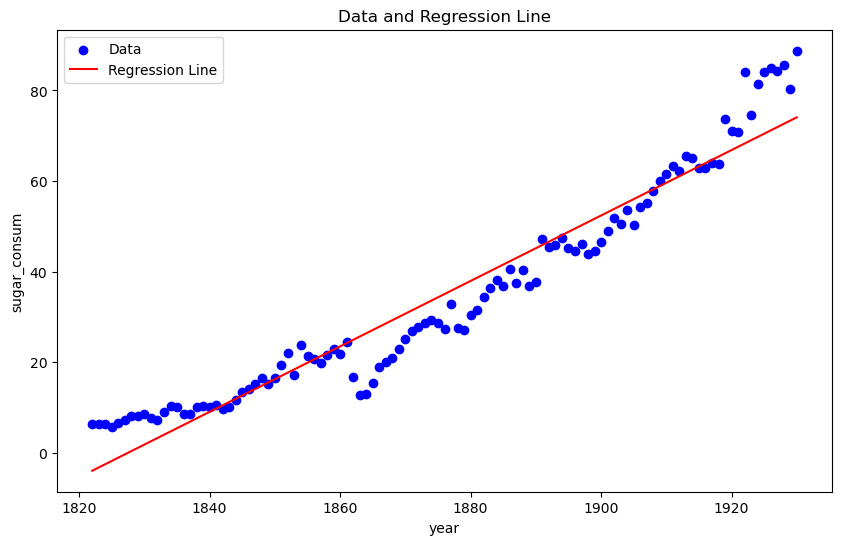


분산 분석
             df        sum_sq       mean_sq            F        PR(>F)
year        1.0  56386.274897  56386.274897  1448.861305  5.046634e-64
Residual  107.0   4164.188381     38.917648          NaN           NaN

잔차 제곱합(SSE)
Deviance: 4164.188381216061

Confidence Intervals:
                     0            1
Intercept -1391.694243 -1250.422924
year          0.685216     0.760510
SSE: 4164.188381216061, MSE: 38.917648422580015

반응변수의 추정

Prediction results for unique x values:
     year  sugar_consum       mean   mean_se  mean_ci_lower  mean_ci_upper  \
0    1822     -4.002622  -4.002622  1.186885      -6.355482      -1.649761   
1    1823     -3.279759  -3.279759  1.170515      -5.600169      -0.959349   
2    1824     -2.556896  -2.556896  1.154226      -4.845015      -0.268778   
3    1825     -1.834033  -1.834033  1.138021      -4.090027       0.421960   
4    1826     -1.111171  -1.111171  1.121903      -3.335212       1.112870   
..    ...           ...        ...       

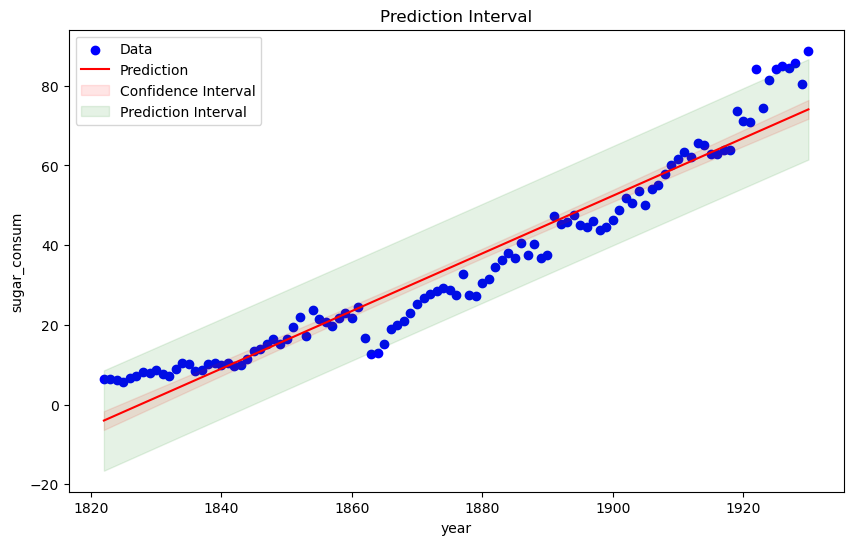


잔차 분석


<Figure size 1500x1000 with 0 Axes>

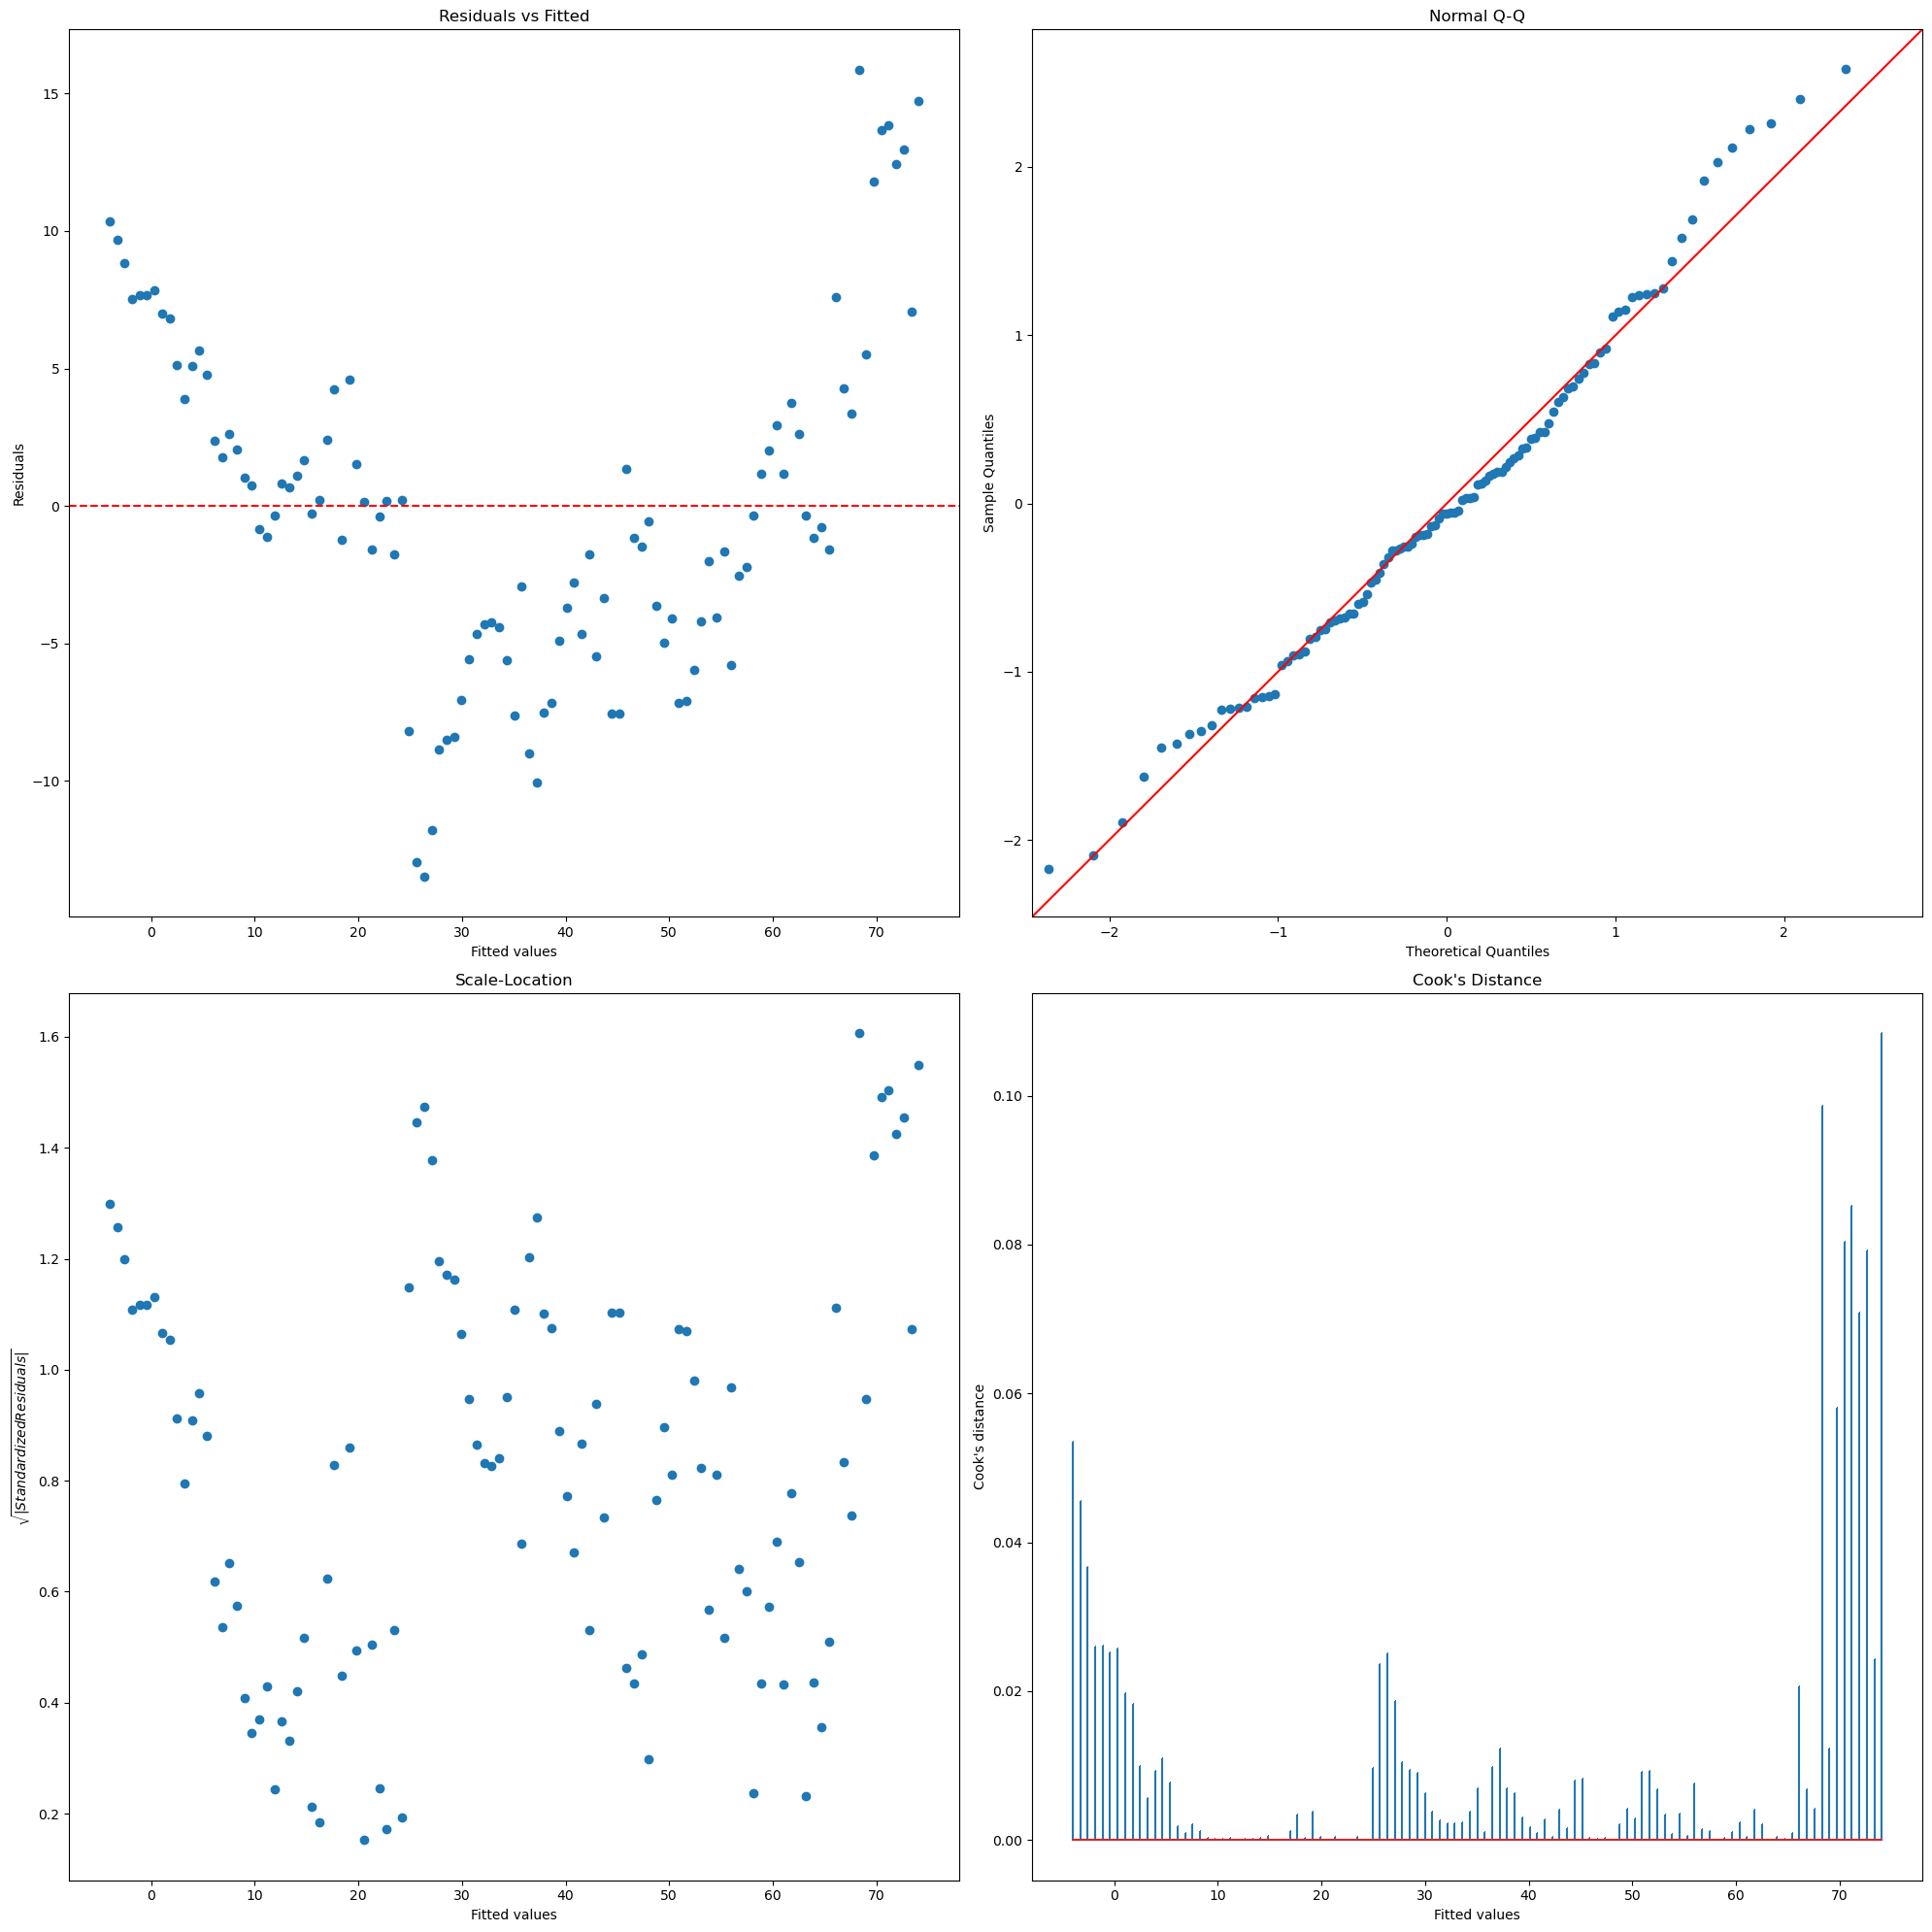



 1931~1960
                            OLS Regression Results                            
Dep. Variable:           sugar_consum   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                   0.05409
Date:                Tue, 22 Oct 2024   Prob (F-statistic):              0.818
Time:                        19:23:46   Log-Likelihood:                -83.376
No. Observations:                  30   AIC:                             170.8
Df Residuals:                      28   BIC:                             173.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    115.5090    165.549      0

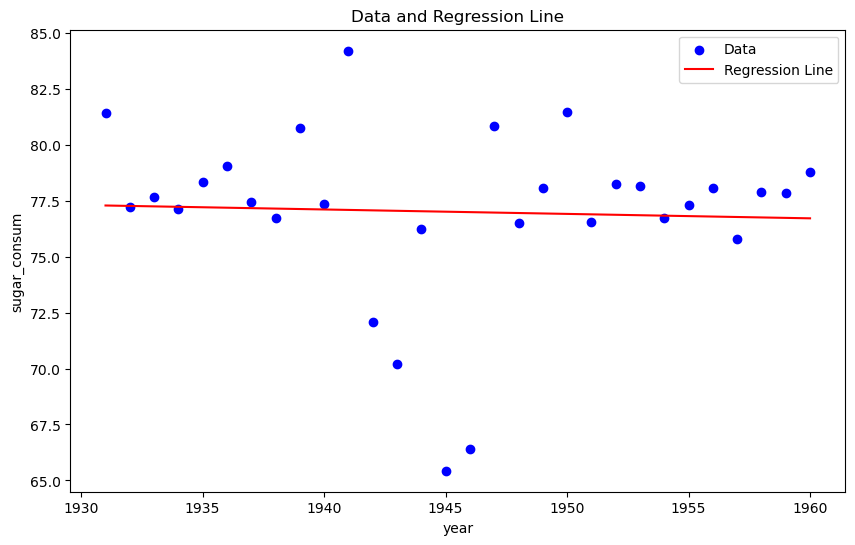


분산 분석
            df      sum_sq    mean_sq         F    PR(>F)
year       1.0    0.880244   0.880244  0.054091  0.817784
Residual  28.0  455.658577  16.273521       NaN       NaN

잔차 제곱합(SSE)
Deviance: 455.65857723426166

Confidence Intervals:
                    0           1
Intercept -223.602611  454.620710
year        -0.194094    0.154514
SSE: 455.65857723426166, MSE: 16.273520615509344

반응변수의 추정

Prediction results for unique x values:
    year  sugar_consum       mean   mean_se  mean_ci_lower  mean_ci_upper  \
0   1931     77.294031  77.294031  1.436945      74.350582      80.237480   
1   1932     77.274241  77.274241  1.364578      74.479030      80.069451   
2   1933     77.254450  77.254450  1.293759      74.604304      79.904596   
3   1934     77.234660  77.234660  1.224760      74.725854      79.743466   
4   1935     77.214870  77.214870  1.157903      74.843012      79.586727   
5   1936     77.195080  77.195080  1.093584      74.954975      79.435185   
6   1937     

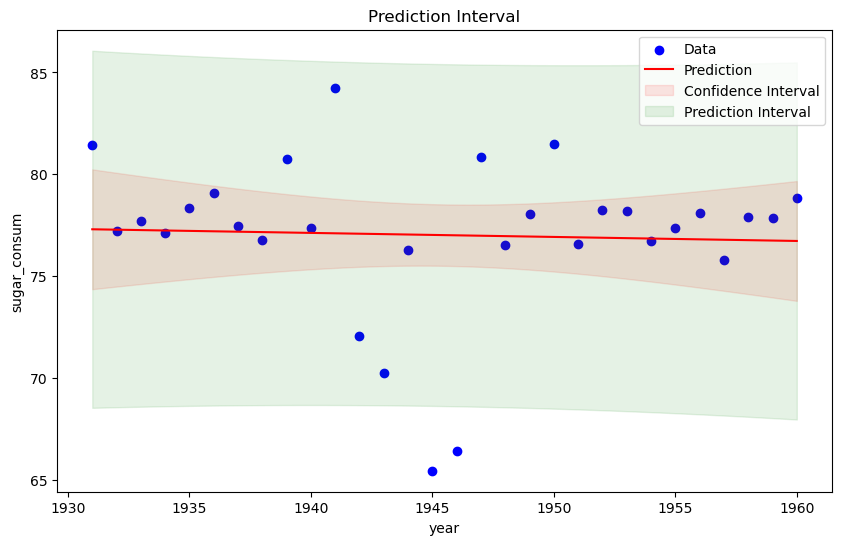


잔차 분석


<Figure size 1500x1000 with 0 Axes>

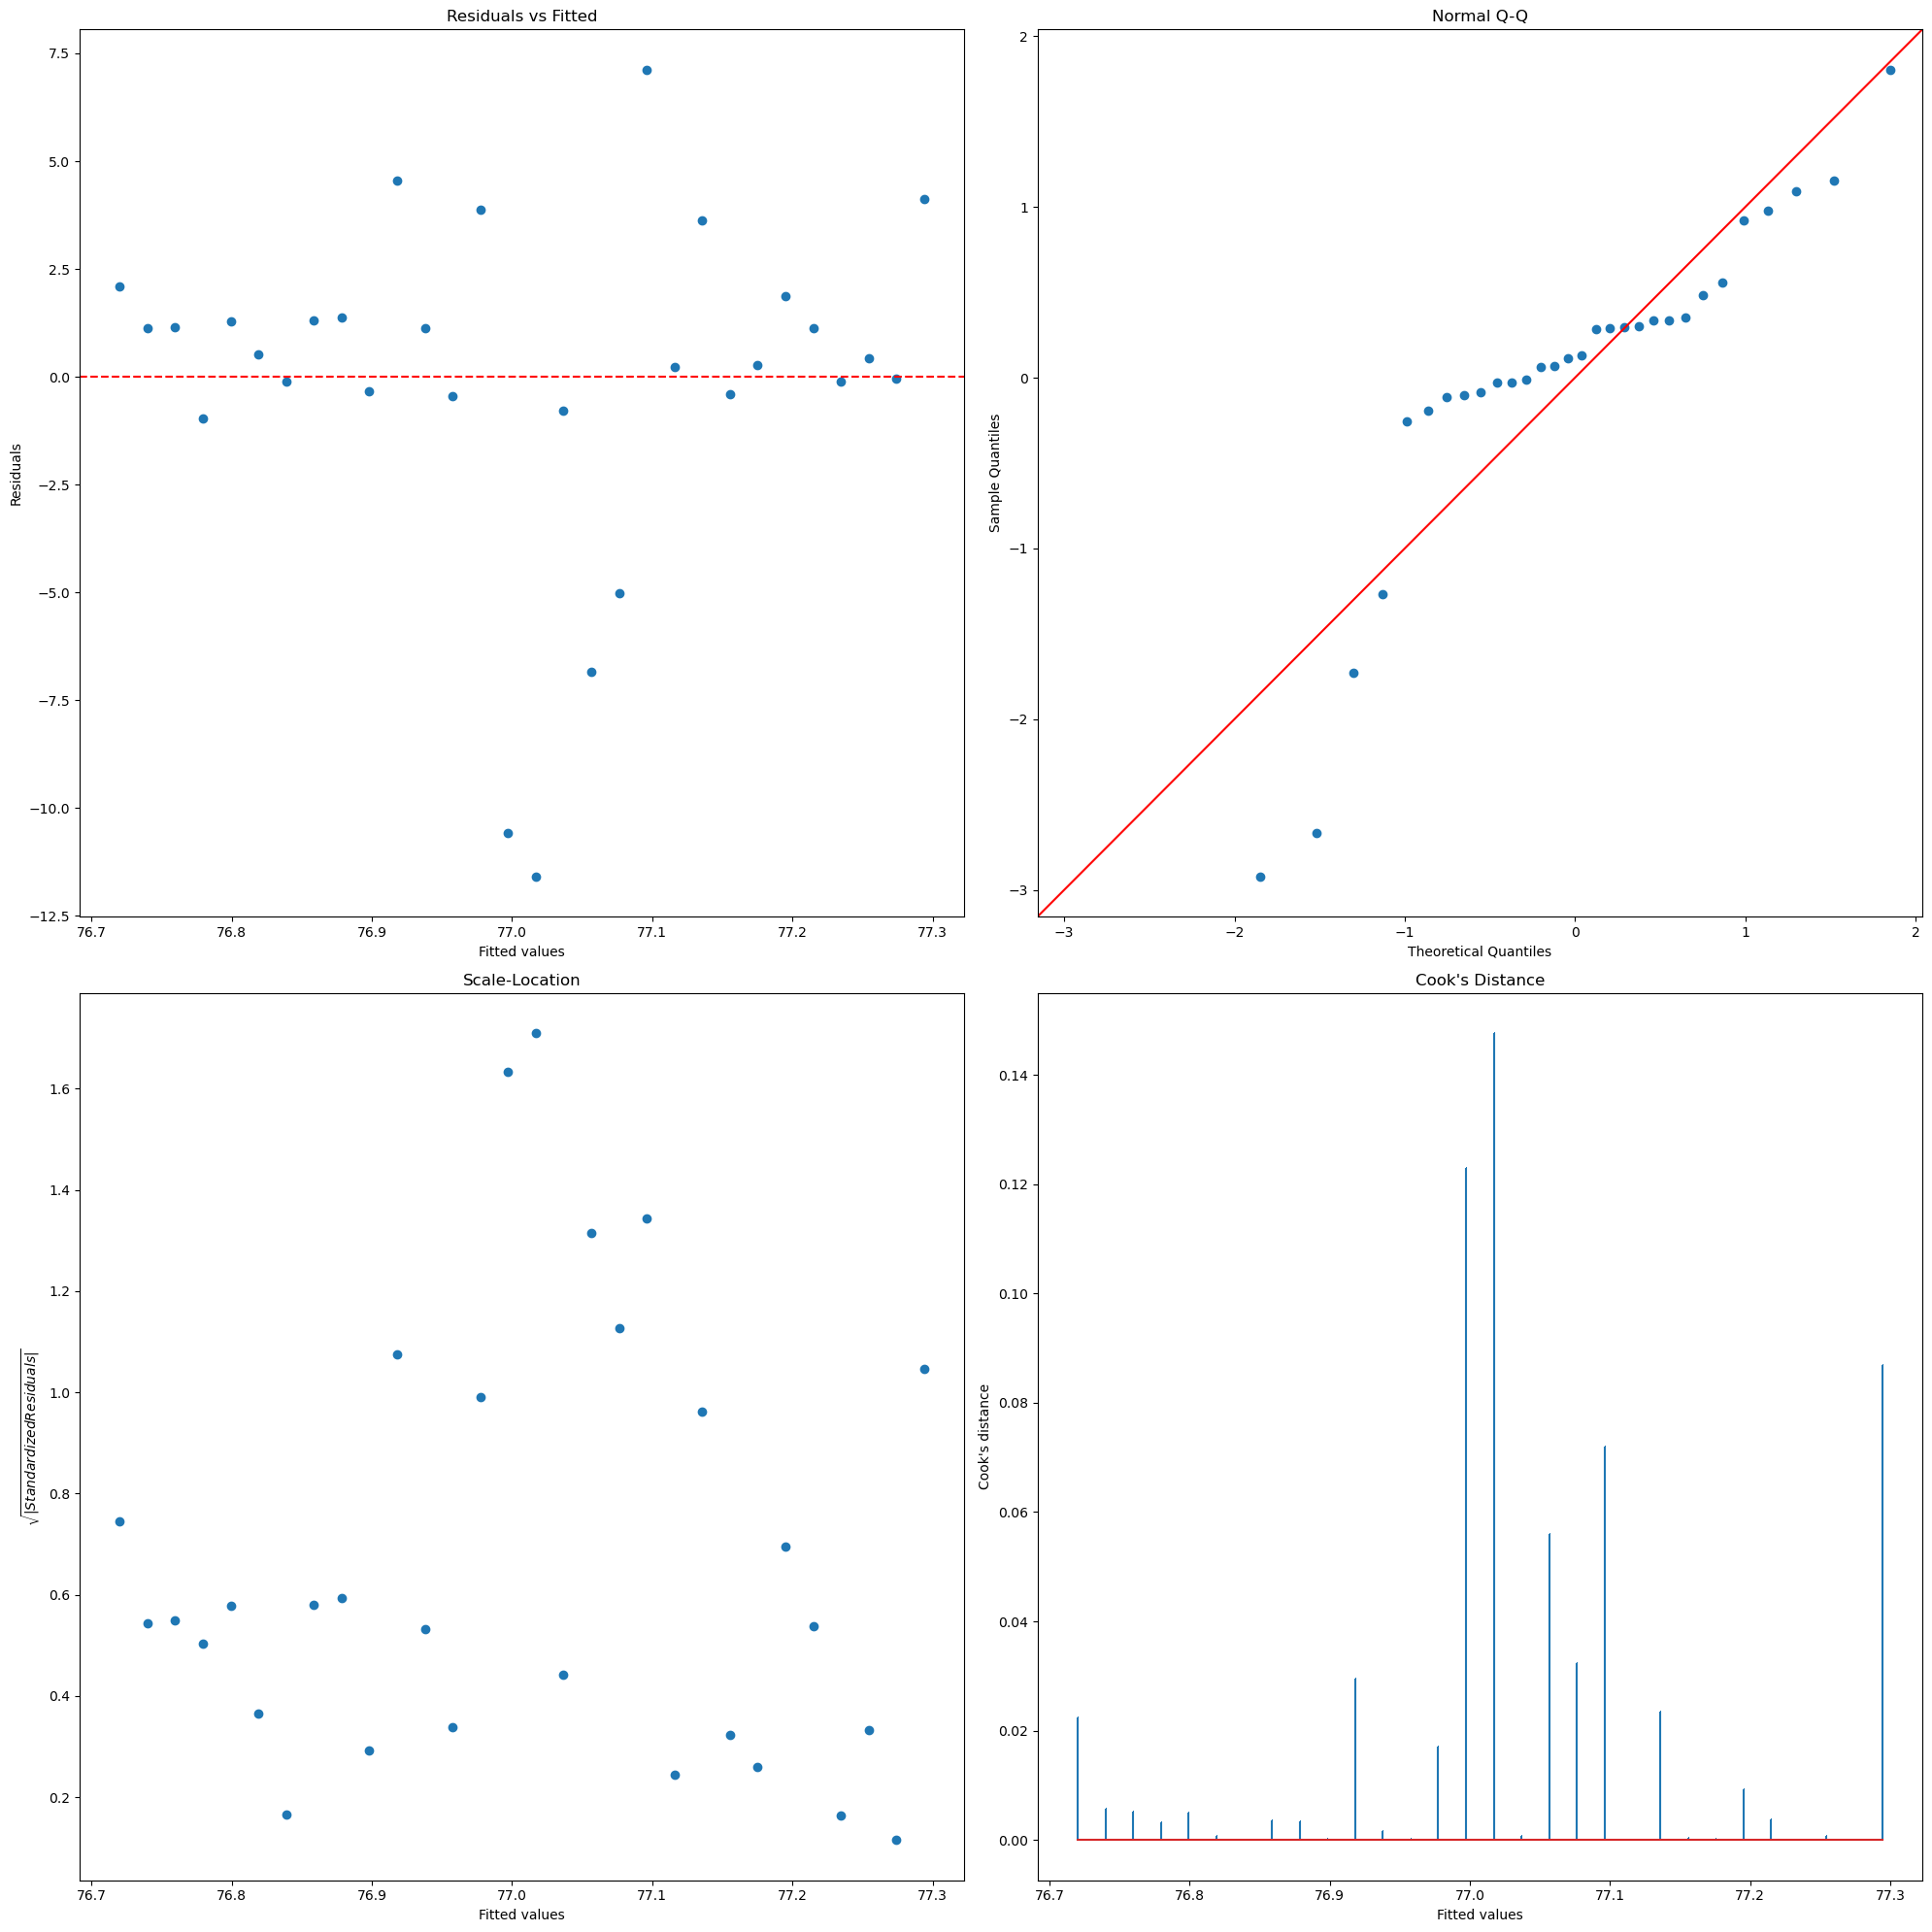



 1961~2005
                            OLS Regression Results                            
Dep. Variable:           sugar_consum   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     288.7
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           1.08e-20
Time:                        19:23:48   Log-Likelihood:                -116.23
No. Observations:                  45   AIC:                             236.5
Df Residuals:                      43   BIC:                             240.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1176.2446     74.572    -15

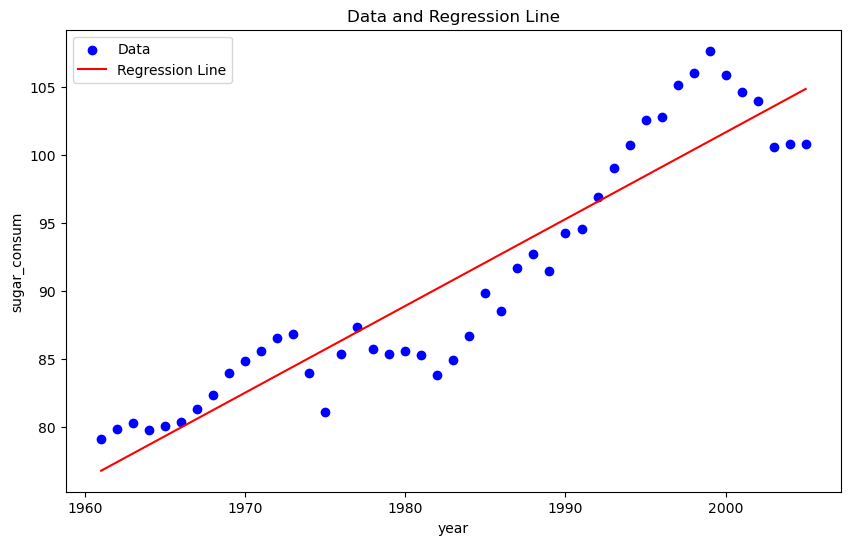


분산 분석
            df       sum_sq      mean_sq           F        PR(>F)
year       1.0  3098.818087  3098.818087  288.710788  1.083038e-20
Residual  43.0   461.531689    10.733295         NaN           NaN

잔차 제곱합(SSE)
Deviance: 461.5316890219527

Confidence Intervals:
                     0            1
Intercept -1326.634066 -1025.855221
year          0.563127     0.714803
SSE: 461.5316890219527, MSE: 10.733295093533783

반응변수의 추정

Prediction results for unique x values:
    year  sugar_consum        mean   mean_se  mean_ci_lower  mean_ci_upper  \
0   1961     76.765962   76.765962  0.960708      74.828510      78.703414   
1   1962     77.404927   77.404927  0.928521      75.532385      79.277469   
2   1963     78.043892   78.043892  0.896756      76.235410      79.852374   
3   1964     78.682857   78.682857  0.865460      76.937491      80.428224   
4   1965     79.321822   79.321822  0.834684      77.638521      81.005124   
5   1966     79.960788   79.960788  0.804489      78.

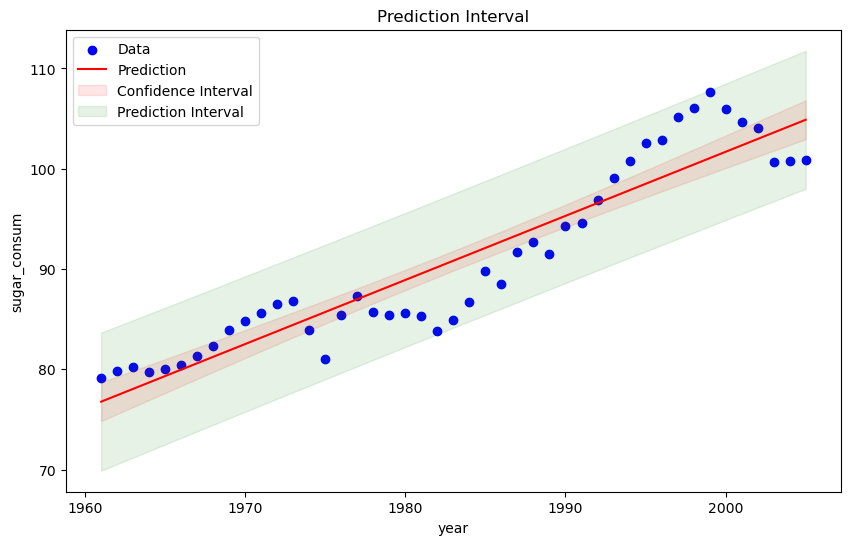


잔차 분석


<Figure size 1500x1000 with 0 Axes>

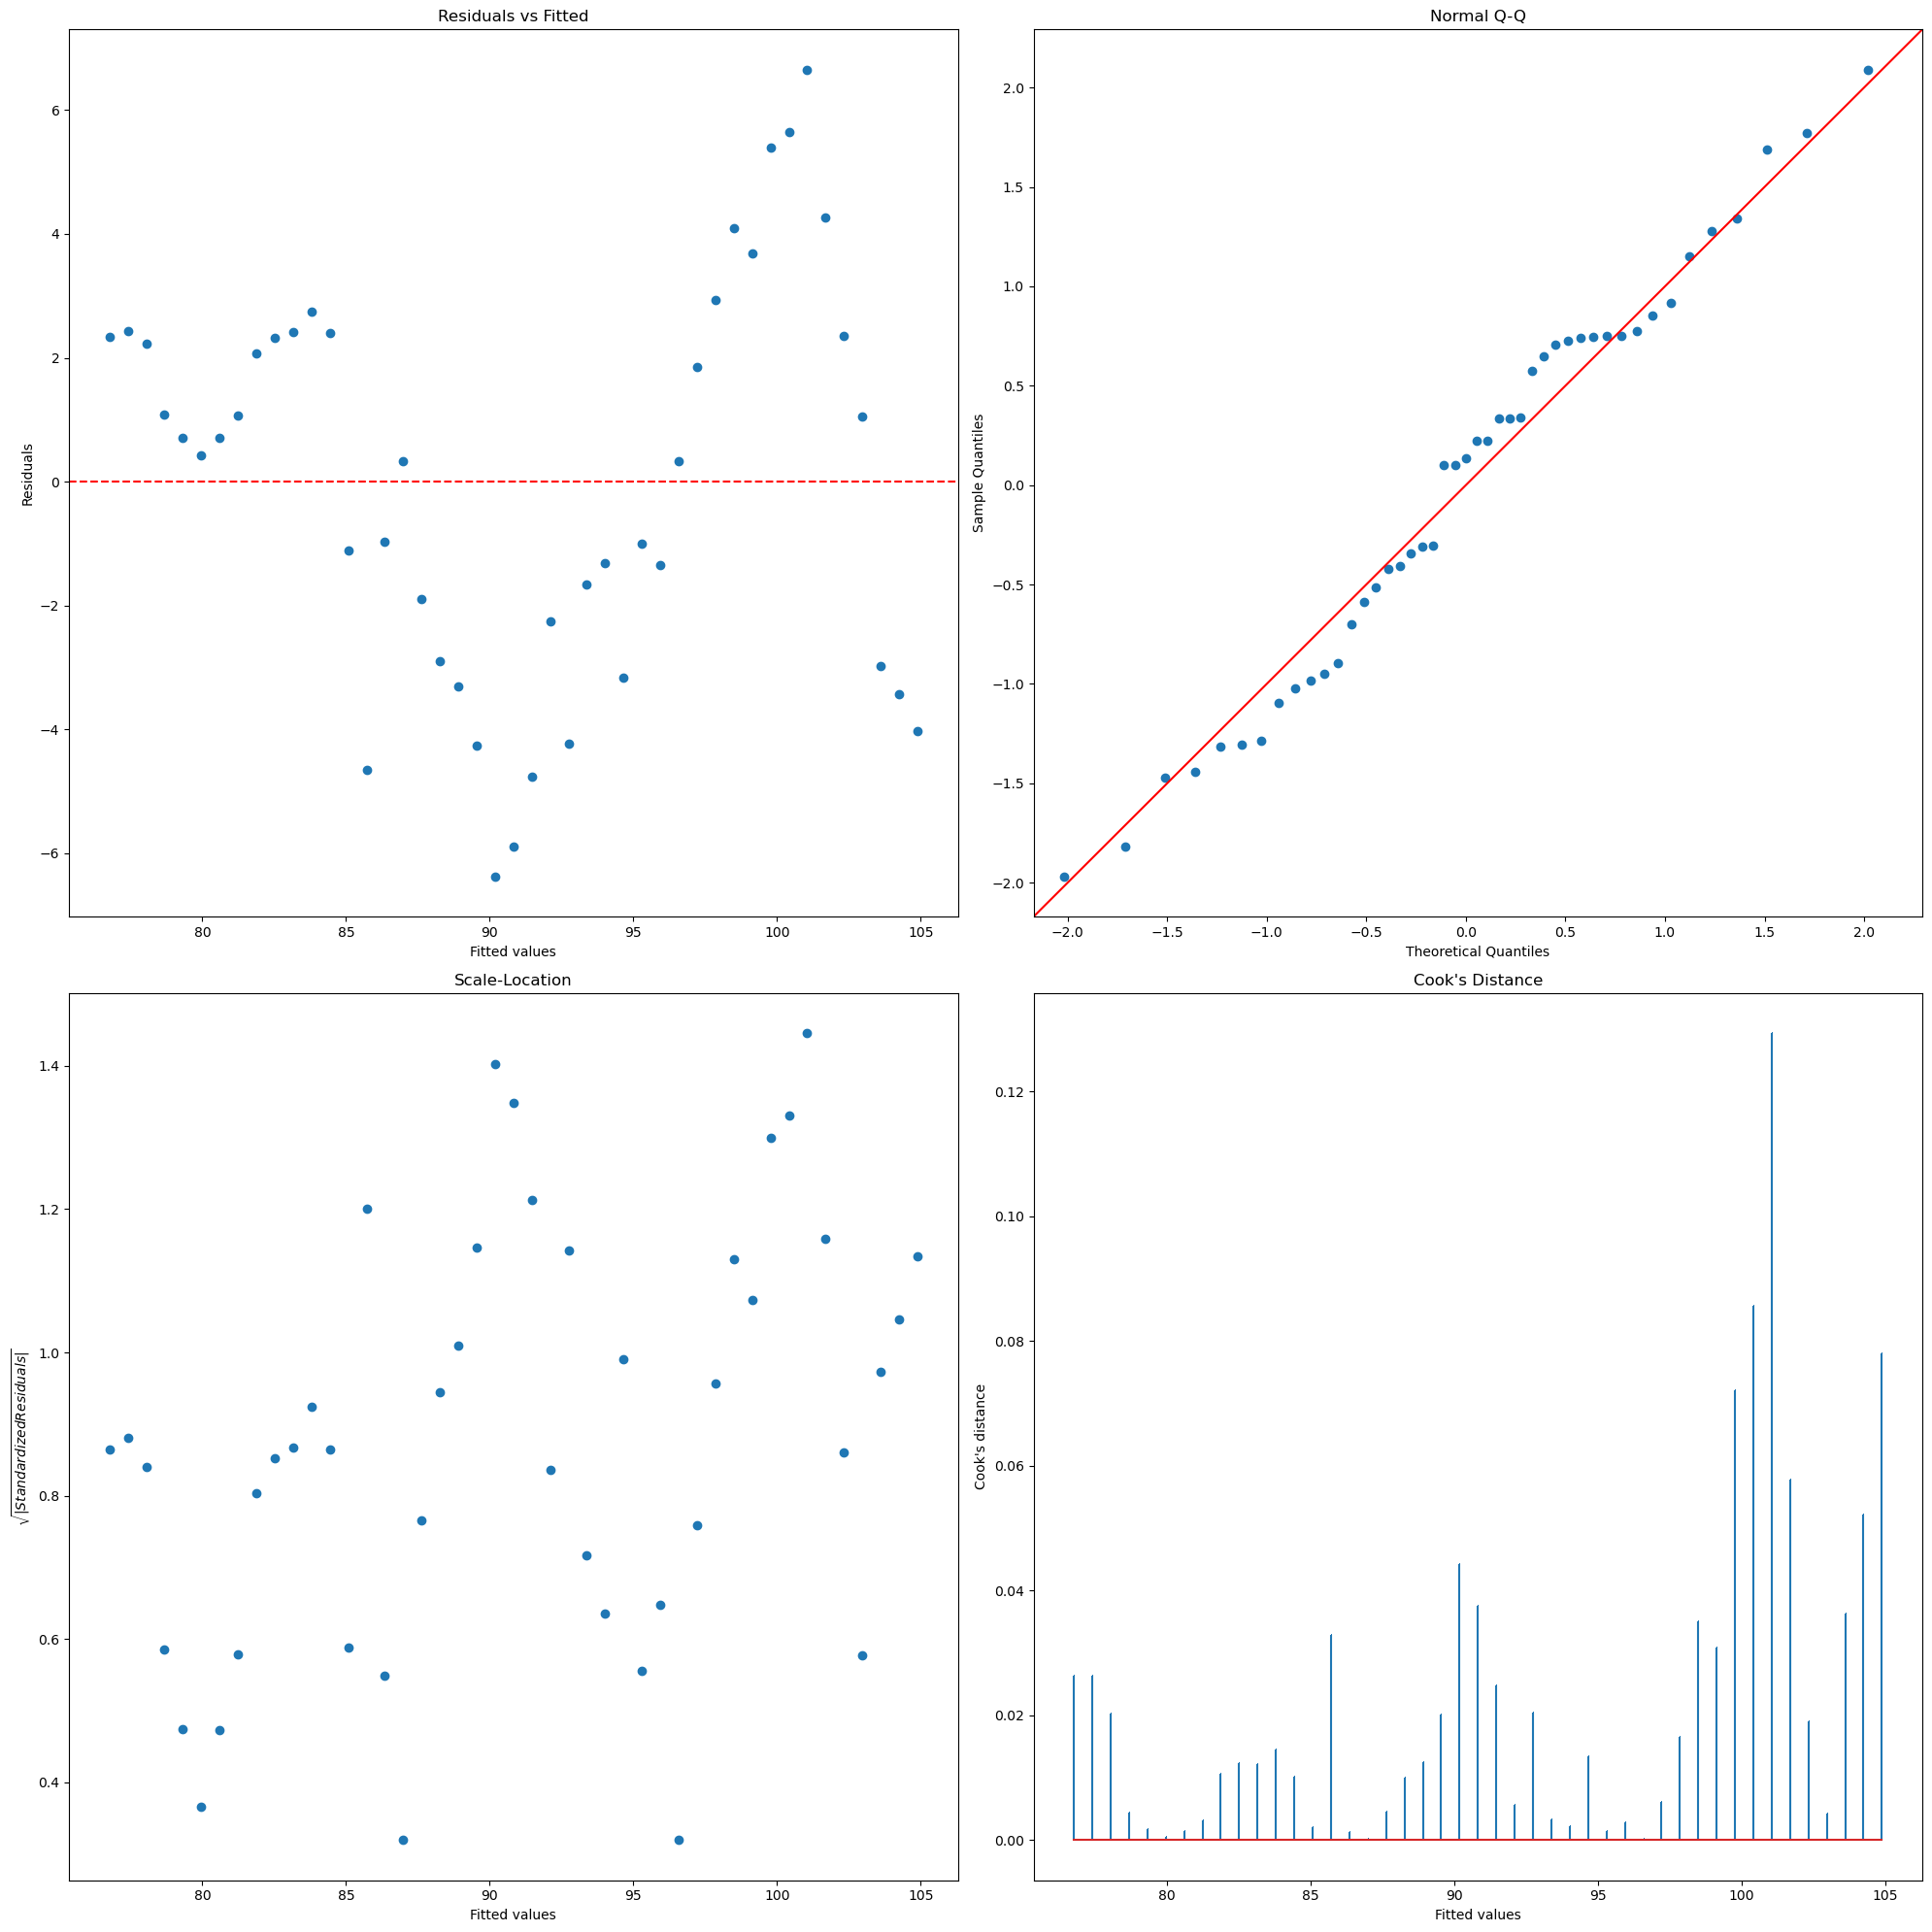

In [42]:
for i, (key, df) in enumerate(df_dict.items()):
    print("\n\n",key)
    linear_regression_analysis(df, df.columns)